In [1]:
import tensorflow as tf 
from tensorflow.python.ops import rnn, rnn_cell
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


if(tf.__version__.split('.')[0]=='2'):
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior() 

In [2]:
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [3]:
hyper = ["adam" , 1e-4, "Basic RNN", 512]
#hyper = ["adam" , 1e-4, "LSTM", 512] or hyper = ["adam" , 1e-4, "GRU", 256]
learningRate = hyper[1]
trainingIters = 20000
batchSize = 100
displayStep = 10

nInput = 28 #we want the input to take the 28 pixels
nSteps = 28 #every 28
nHidden = hyper[3] #number of neurons for the RNN
nClasses = 10 #this is MNIST so you know

x = tf.placeholder('float', [None, nSteps, nInput])
y = tf.placeholder('float', [None, nClasses])

weights = {'out': tf.Variable(tf.random_normal([nHidden, nClasses]))}

biases = {'out': tf.Variable(tf.random_normal([nClasses]))}

In [4]:
def RNN(x, weights, biases):
    x = tf.transpose(x, [1,0,2])
    x = tf.reshape(x, [-1, nInput])
    x = tf.split(x, nSteps, 0) #configuring so you can get it as needed for the 28 pixels

    lstmCell = rnn_cell.BasicRNNCell(nHidden)#find which lstm to use in the documentation
    #lstmCell = rnn_cell.BasicLSTMCell(nHidden, forget_bias = 1)
    #lstmCell = rnn_cell.BasicGRUCell(nHidden, forget_bias = 1)
    outputs, states = rnn.static_rnn(lstmCell, x, dtype=tf.float32) #for the rnn where to get the output and hidden state 

    return tf.matmul(outputs[-1], weights['out'])+ biases['out']
pred = RNN(x, weights, biases)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:


#optimization
#create the cost, optimization, evaluation, and accuracy
#for the cost softmax_cross_entropy_with_logits seems really good
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(cost)

correctPred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

train_acc=[]
test_acc=[]
loss_log1=[]
loss_log2=[]

init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    testset = mnist.test.images.reshape((-1,nSteps, nInput))
    testlabel = mnist.test.labels 

    while step* batchSize < trainingIters:
        batchX, batchY = mnist.train.next_batch(batchSize)#mnist has a way to get the next batch
        batchX = batchX.reshape((batchSize, nSteps, nInput))

        sess.run(optimizer, feed_dict={x: batchX , y: batchY})

        if step % displayStep == 0:
            acc = sess.run(accuracy,feed_dict={x: batchX, y: batchY})
            loss = sess.run(cost,feed_dict={x: batchX, y: batchY})
            print("Iter" + str(step*batchSize) + ", Minibatch Loss= " + "{:.6f}".format(loss)+", Training Accuracy= " + "{:,.5f}".format(acc))
            train_acc.append(acc)
            test_acc.append(sess.run(accuracy,feed_dict={x: testset, y: testlabel}))
            
            loss_log1.append(loss)
            loss_log2.append(sess.run(cost,feed_dict={x: testset, y: testlabel}))
        
        step +=1
    print('Optimization finished')

    testData = mnist.test.images.reshape((-1, nSteps, nInput))
    testLabel = mnist.test.labels
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: testData, y: testLabel}))

Iter1000, Minibatch Loss= 2.372909, Training Accuracy= 0.36000
Iter2000, Minibatch Loss= 1.336633, Training Accuracy= 0.64000
Iter3000, Minibatch Loss= 0.776955, Training Accuracy= 0.74000
Iter4000, Minibatch Loss= 0.790601, Training Accuracy= 0.79000
Iter5000, Minibatch Loss= 0.732180, Training Accuracy= 0.76000
Iter6000, Minibatch Loss= 1.204021, Training Accuracy= 0.75000
Iter7000, Minibatch Loss= 0.625540, Training Accuracy= 0.82000
Iter8000, Minibatch Loss= 0.416081, Training Accuracy= 0.90000
Iter9000, Minibatch Loss= 0.926337, Training Accuracy= 0.76000
Iter10000, Minibatch Loss= 0.484285, Training Accuracy= 0.82000
Iter11000, Minibatch Loss= 0.626511, Training Accuracy= 0.84000
Iter12000, Minibatch Loss= 0.468949, Training Accuracy= 0.89000
Iter13000, Minibatch Loss= 0.319082, Training Accuracy= 0.91000
Iter14000, Minibatch Loss= 0.272673, Training Accuracy= 0.90000
Iter15000, Minibatch Loss= 0.388802, Training Accuracy= 0.88000
Iter16000, Minibatch Loss= 0.404457, Training Acc

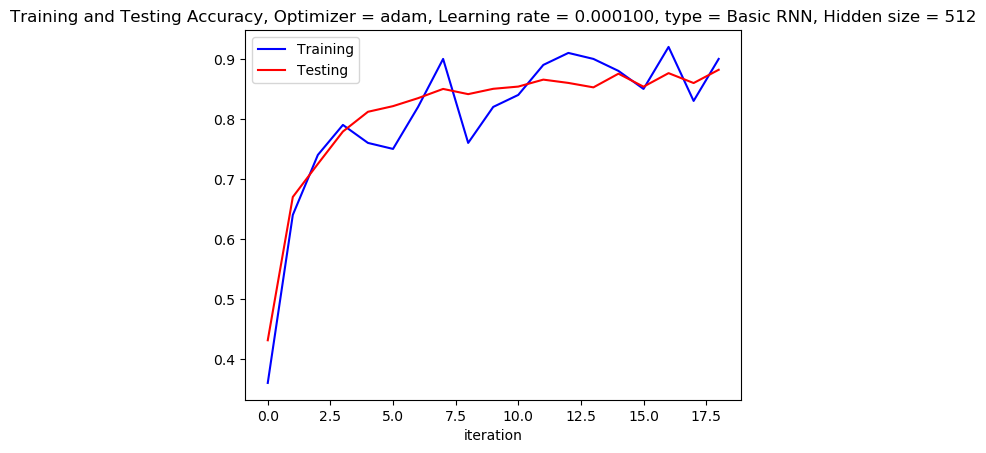

In [7]:
plt.plot(train_acc, 'b', label = "Training")
plt.plot(test_acc, 'r', label = "Testing")
plt.xlabel('iteration')
plt.title("Training and Testing Accuracy, Optimizer = %s"% hyper[0] + ", Learning rate = %f" % hyper[1] + ", type = %s"% hyper[2] + ", Hidden size = %i" %hyper[3])
plt.legend(loc='upper left')
plt.show()

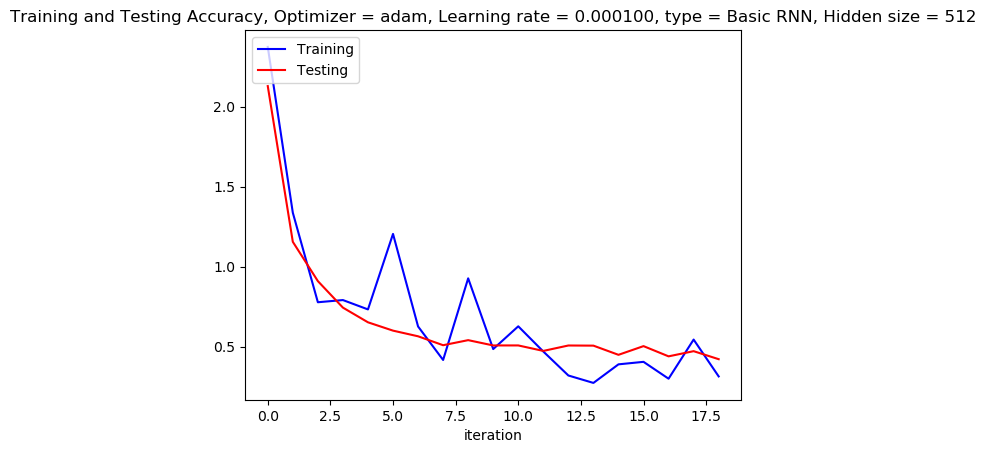

In [8]:
plt.plot(loss_log1, 'b', label = "Training")
plt.plot(loss_log2, 'r', label = "Testing")
plt.xlabel('iteration')
plt.title("Training and Testing Accuracy, Optimizer = %s"% hyper[0] + ", Learning rate = %f" % hyper[1] + ", type = %s"% hyper[2] + ", Hidden size = %i" %hyper[3])
plt.legend(loc='upper left')
plt.show()